# Détection des sources sismiques

In [1]:
import pandas as pd
import numpy as np
import struct
import matplotlib
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import pickle

import tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction import settings, ComprehensiveFCParameters, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
import xgboost as xgb

In [3]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

## Chargement des données

In [40]:
path = "SUHA_Paris2017"
# part = 2 # choisir parmi 0, 1, 2, 3, 4
# nb_part = 5

all_files = [path + "/" + f for f in listdir(path) if isfile(join(path, f))]

start = 29 # part * int(len(all_files) / nb_part)
stop = 69 # (part + 1) * int(len(all_files) / nb_part)
some_files = all_files[start:stop:4]
some_files

['SUHA_Paris2017/conBR_ir031_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir035_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir039_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir043_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir048_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir052_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir056_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir029_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir060_tostack.rsf@',
 'SUHA_Paris2017/conBR_ir064_tostack.rsf@']

In [5]:
n1_convH = 75
n2_convH = 5400
n3_convH = 100

In [6]:
def load_data(filename):
    """
    Charger le fichier de données
    """
    n_elems = n1_convH * n2_convH * n3_convH
    f = open(filename, "rb")
    data = struct.unpack('f' * n_elems, f.read(4 * n_elems))
    f.close()
    return np.reshape(data, (n3_convH, n2_convH, n1_convH))

In [7]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
convH = load_data(all_files[50])

## Normalisation

In [9]:
def normalize_signals(data):
    """
    Normaliser le signal par rapport au temps
    """
    for receiver in range(n3_convH):
        for trace in range(n2_convH):
            data[receiver, trace] = data[receiver, trace, :] / np.amax(data[receiver, trace], axis=0)
    return data

In [10]:
n_convH = normalize_signals(convH)

## Représentation des traces sismiques après convolution

In [11]:
receiver = 50

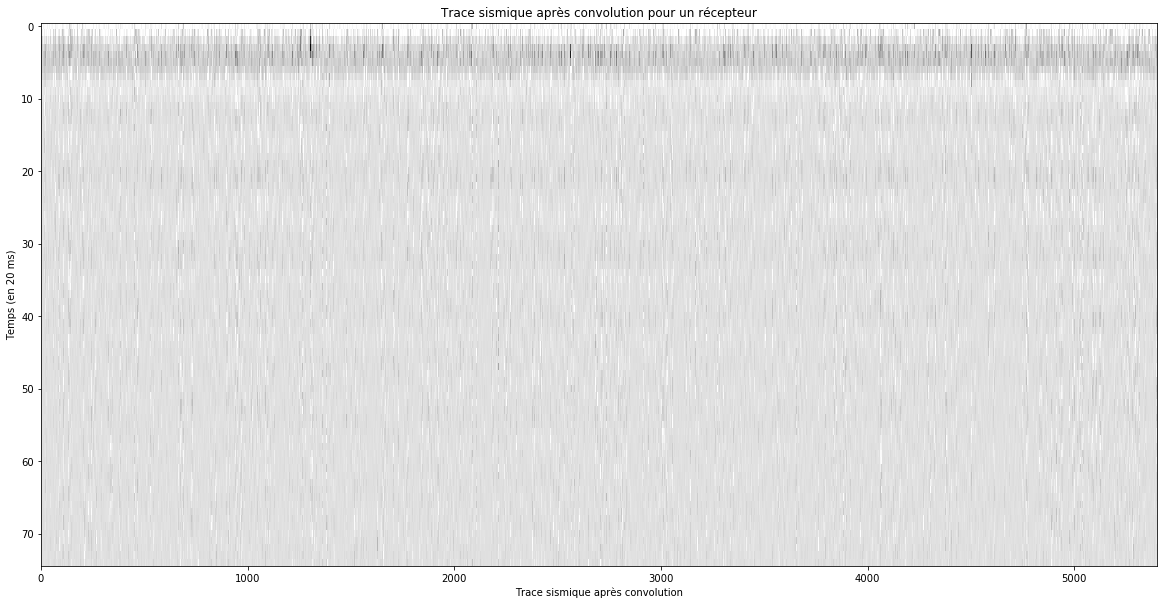

In [12]:
plt.close('all')
plt.imshow(n_convH[receiver].T, cmap='gray', aspect="auto")
plt.xlabel("Trace sismique après convolution")
plt.ylabel("Temps (en 20 ms)")
plt.title("Trace sismique après convolution pour un récepteur")
plt.show()

In [13]:
def compute_sums(data, n_tracesByGroups=20):
    """
    Calculer la somme des traces par groupe de 20
    """
    n3, n2, n1 = data.shape
    n_groups = int(n2 / n_tracesByGroups)

    sum_traces_grouped = np.zeros((n3, n_groups, n1))
    sum_traces = np.zeros((n3, n1))
    
    for receiver in range(n3):
        traces = data[receiver]
        sum_traces[receiver, :] = traces.sum(axis=0) / np.amax(np.abs(traces.sum(axis=0)))
        for n_group in range(n_groups):
            start = n_tracesByGroups * n_group
            stop = n_tracesByGroups * (n_group + 1)
            sum_traces_grouped[receiver, n_group, :] = traces[start:stop, :].sum(axis=0) / np.amax(np.abs(traces[start:stop, :].sum(axis=0)))
    
    return sum_traces, sum_traces_grouped

In [14]:
def compute_SSE(u_vgt, u):
    """
    Calculer la somme de l'écart quadratique
    """
    n3, n2, n1 = u.shape
    SSE = np.zeros((n3, n2))
    for receiver in range(n3):
        for group in range(n2):
            SSE[receiver, group] = np.square(u_vgt[receiver] - u[receiver, group, :]).sum()
    return SSE

In [15]:
sum_traces, sum_traces_grouped = compute_sums(n_convH, n_tracesByGroups=20)

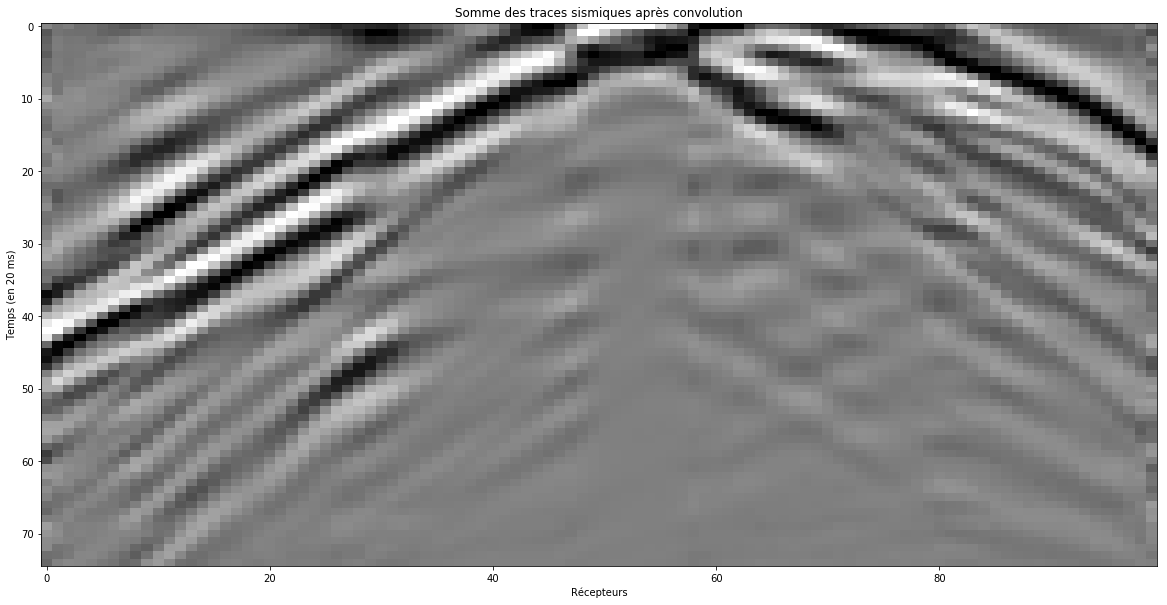

In [16]:
plt.close('all')
plt.imshow(sum_traces.T, cmap='gray', aspect="auto")
plt.xlabel("Récepteurs")
plt.ylabel("Temps (en 20 ms)")
plt.title("Somme des traces sismiques après convolution")
plt.show()

In [17]:
sumH = compute_SSE(sum_traces, sum_traces_grouped)

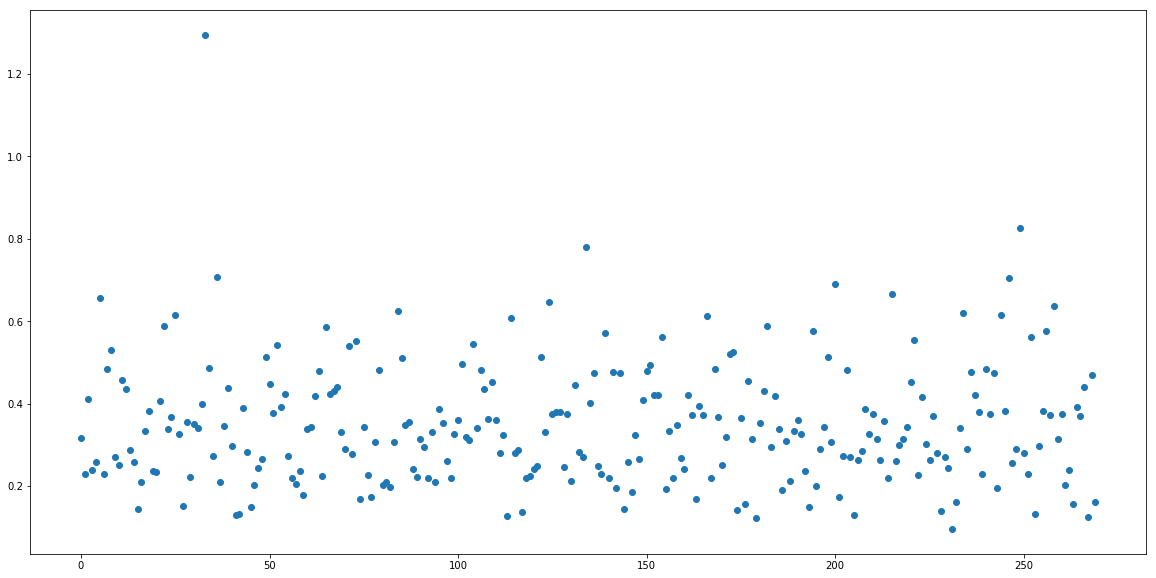

In [18]:
plt.plot(sumH[receiver], 'o')
plt.show()

## Etiquettage des traces sismiques groupées

- Classe 0: la trace sismique groupée ressemble à la sommation des traces sismiques sur 6 heures
- Classe 1: la trace sismique groupée ne ressemble pas à la sommation des traces sismiques sur 6 heures

In [19]:
receiver = 51

In [20]:
def labelize(sumH, receiver):
    """
    Etiquetter l'échantillon
    """
    decision = np.median(sumH[receiver]) # 2.5
    y_todf = np.zeros(sumH[receiver].shape)
    y_todf = y_todf + (sumH[receiver] < decision).astype(np.int)
    return pd.DataFrame(y_todf)[0]

In [21]:
y = labelize(sumH, receiver)

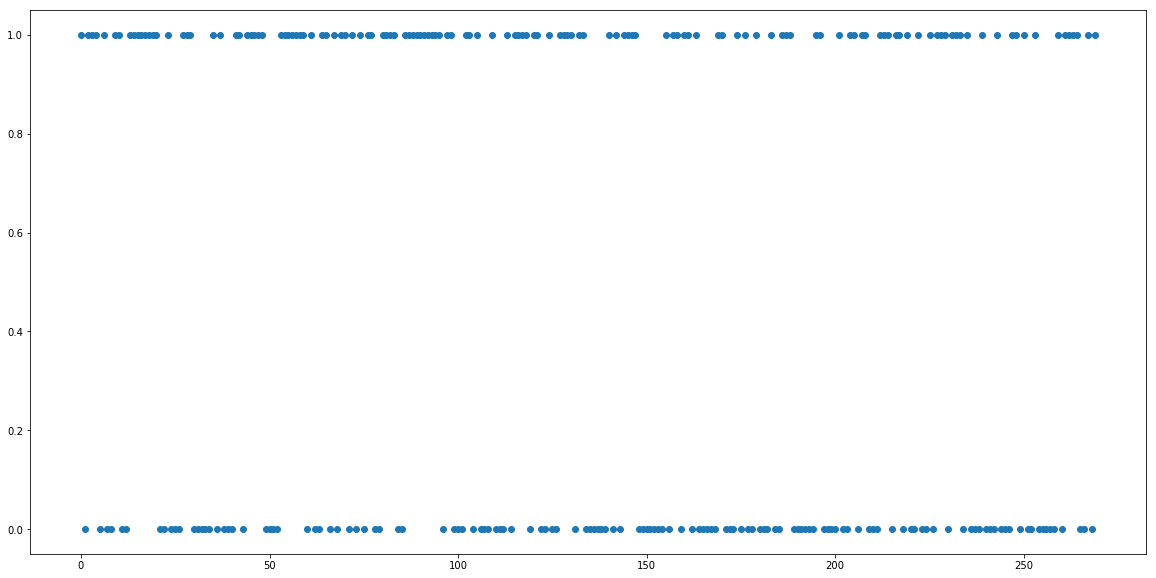

In [22]:
plt.plot(y, 'o')
plt.show()

## Extraction des caractéristiques

In [23]:
def extractFeatures(sum_traces_grouped, receiver, main_features=None):
    """
    Extraire les caractéristiques pour chaque récepteur
    """
    master_df = pd.DataFrame(sum_traces_grouped[receiver, 0])
    master_df['id'] = 0
    for ii in range(1, sum_traces_grouped.shape[1]):
        temp_df = pd.DataFrame(sum_traces_grouped[receiver, ii])
        temp_df['id'] = ii
        master_df = pd.DataFrame(np.vstack([master_df, temp_df]))
    # 75 * 270 -1 = 20 249
    
    extraction_settings = EfficientFCParameters()
    extraction_settings.IMPUTE = impute # Interpolation pour éviter les valeurs NaN
    
    kind_to_fc_parameters = {}
    if main_features !=None:
        kind_to_fc_parameters = load_obj(main_features)
    
    return extract_features(master_df, column_id=1,
                            default_fc_parameters=extraction_settings,
                            kind_to_fc_parameters=kind_to_fc_parameters).sort_index()

In [24]:
%time X = extractFeatures(sum_traces_grouped, receiver)
print(X.shape)

Feature Extraction: 100%|██████████| 270/270 [00:23<00:00, 11.54it/s]

CPU times: user 904 ms, sys: 28 ms, total: 932 ms
Wall time: 23.7 s
(270, 216)


## Premiers modèles

In [25]:
def classification_metrics(y, y_pred):
    """
    Métriques de classification
    """
    print(classification_report(y, y_pred))

#### Méthodes d'ensemble

In [26]:
clf = DecisionTreeClassifier()
%time y_pred = cross_val_predict(clf, X, y, cv=10)
classification_metrics(y, y_pred)

CPU times: user 176 ms, sys: 4 ms, total: 180 ms
Wall time: 176 ms
             precision    recall  f1-score   support

        0.0       0.75      0.75      0.75       135
        1.0       0.75      0.75      0.75       135

avg / total       0.75      0.75      0.75       270



In [ ]:
tree = DecisionTreeClassifier()
clf = BaggingClassifier(tree, n_estimators=200)
%time y_pred = cross_val_predict(clf, X, y, cv=10)
classification_metrics(y, y_pred)

In [ ]:
clf = RandomForestClassifier(n_estimators=200)
%time y_pred = cross_val_predict(clf, X, y, cv=10)
classification_metrics(y, y_pred)

In [ ]:
clf = ExtraTreesClassifier(n_estimators=200)
%time y_pred = cross_val_predict(clf, X, y, cv=10)
classification_metrics(y, y_pred)

In [ ]:
def xgb_cross_val_predict(params, X, y, cv=10):
    """
    Cross validation avec Xgboost
    """
    dX = xgb.DMatrix(X.values, label=y.values)

    n, p = X.shape
    print(n, p)
    
    bst = xgb.train(params, dX, num_round)

    preds = bst.predict(dX)
    return preds

In [ ]:
params = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic'}
num_round = 2
%time y_pred = xgb_cross_val_predict(params, X, y, cv=10)
# classification_metrics(y, y_pred)

#### Réseaux de neurones

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(300, 50, 100),
                  activation='relu', solver='adam', max_iter=500, early_stopping=False)
%time y_pred = cross_val_predict(clf, X, y, cv=10)
classification_metrics(y, y_pred)

#### Machine à vecteur support

In [ ]:
clf = SVC(C=0.5, kernel='rbf', degree=3)
%time y_pred = cross_val_predict(clf, X, y, cv=10)
classification_metrics(y, y_pred)

https://xgboost.readthedocs.io/en/latest/

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

## Importance des caractéristiques

In [27]:
def explicability(weights, columns, first=10):
    """
    Représenter le poids des variables explicatives
    """
    weights = weights.reshape(-1)
    idx = weights.argsort()[::-1][:first]
    x = np.arange(first)
    y = weights[idx]
    labels = columns[idx]

    plt.close('all')
    fig, ax = plt.subplots(figsize=(18, 4))

    ax.bar(x, y, width=0.5, align='center')
    ax.set_xlabel(u"Variables explicatives")
    ax.set_ylabel(u"Poids")

    plt.xticks(x, labels, rotation=80)
    plt.title(u"Poids des variables explicatives")
    plt.show()
    
    filename = "features_weights.csv"
    features_weights = []
    with open(filename, 'w') as f:
        for x in zip(labels, y):
            f.write(x[0])
            f.write("\t")
            f.write(str(x[1]))
            f.write("\n")
            features_weights.append(x)
    return labels

In [28]:
def score_with_components(clf, X, y, columns, weights, cv=10):
    """
    Calculer les scores en fonction du nombre de composants
    """
    dict_feat_import = {
        'feature_names': list(columns),
        'feat_importance': list(weights)
    }

    feat_import_df = pd.DataFrame.from_dict(dict_feat_import, orient='columns')
    sort_feat_import_df = feat_import_df.sort_values(by=['feat_importance'],ascending=[0]).reset_index(drop=True)
    sorted_vect_importance = np.sort(weights, kind='heapsort')

    sorted_vect_importance[:] = sorted_vect_importance[::-1]
    score_mean = []
    error_on_mean_score = []
    n_th_most_important_features = []
    last_included_feat = []
    df_X = pd.DataFrame(X, columns=columns)
    df_y = pd.DataFrame(y)

    n_split_cv_n_fold = cv

    for ind in range(sort_feat_import_df.shape[0]):
        if ind % 10 == 0:
            print('ind = ' + ind.__str__())

        # print("Variables explicatives:")
        # print(list(sort_feat_import_df['feature_names'].head(ind+1)))
        last_included_feat.append(list(sort_feat_import_df['feature_names'].head(ind+1))[-1])
        X_new = df_X[list(sort_feat_import_df['feature_names'].head(ind+1))]

        # print(X_new.shape)
        # print("X_new.shape")
        # print('cross val...')

        scores = cross_val_score(clf, X_new, np.ravel(df_y), cv=n_split_cv_n_fold, n_jobs=-1)
        # print(np.std(scores))
        error_on_mean_score.append(np.std(scores) / np.sqrt(n_split_cv_n_fold - 1))
        # print("std scores")
        # print(np.mean(scores))
        score_mean.append(np.mean(scores))
        n_th_most_important_features.append(ind+1)

        # print("mean scores")

        # print('************* \n last included feature and score')
        """for a in range(len(last_included_feat)):
            print(last_included_feat[a] + u"\u0009"*4+'  -->  mean score  :  ' + score_mean[a].__str__())"""
        # print('************* \n last included feature and score (above)')

        # print('******************** \n')
    return n_th_most_important_features, score_mean, error_on_mean_score, sort_feat_import_df

In [29]:
def plot_score_with_components(n_th_most_important_features, score_mean,
                               error_on_mean_score, sort_feat_import_df):
    """
    Tracer les scores en fonction du nombre de composants
    """
    x = n_th_most_important_features
    y = score_mean
    yerr = error_on_mean_score
    plt.clf()
    plt.close()
    plt.close('all')

    fig = plt.figure(figsize=(22.0, 13.0))
    plt.errorbar(x, y, yerr=yerr, fmt='o', linestyle='-', color='b')
    plt.title('mean score for n-th most important features', fontsize=22)
    ax = plt.gca()
    ax.legend_ = None
    plt.xlabel('nb of components considered ', fontsize=22)
    plt.ylabel('scores',fontsize=22)
    plt.legend(numpoints=1, loc=2)  # numpoints = 1 for nicer display
    axes = plt.gca()
    axes.set_xlim([0, sort_feat_import_df.shape[0]])
    plt.tight_layout()
    plt.show()

    plt.clf()
    plt.close()
    plt.close('all')

In [30]:
clf = ExtraTreesClassifier(n_estimators=200)
clf.fit(X, y)
weights = clf.feature_importances_
columns = X.columns

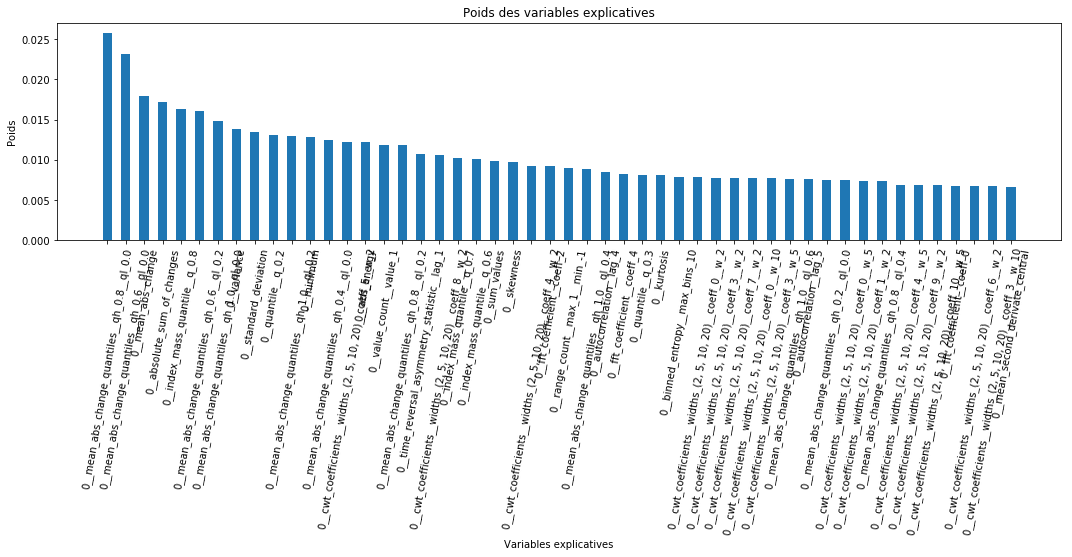

In [31]:
main_features = explicability(weights, columns, first=50)

In [ ]:
kind_to_fc_parameters = settings.from_columns(main_features)
save_obj(kind_to_fc_parameters, "main_features")

In [32]:
most_important_features, score_mean, error_on_mean_score, sort_feat_import_df = score_with_components(
    clf, X, y, columns, weights, cv=10)

ind = 0
ind = 10
ind = 20
ind = 30
ind = 40
ind = 50
ind = 60
ind = 70
ind = 80
ind = 90
ind = 100
ind = 110
ind = 120
ind = 130
ind = 140
ind = 150
ind = 160
ind = 170
ind = 180
ind = 190
ind = 200
ind = 210


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


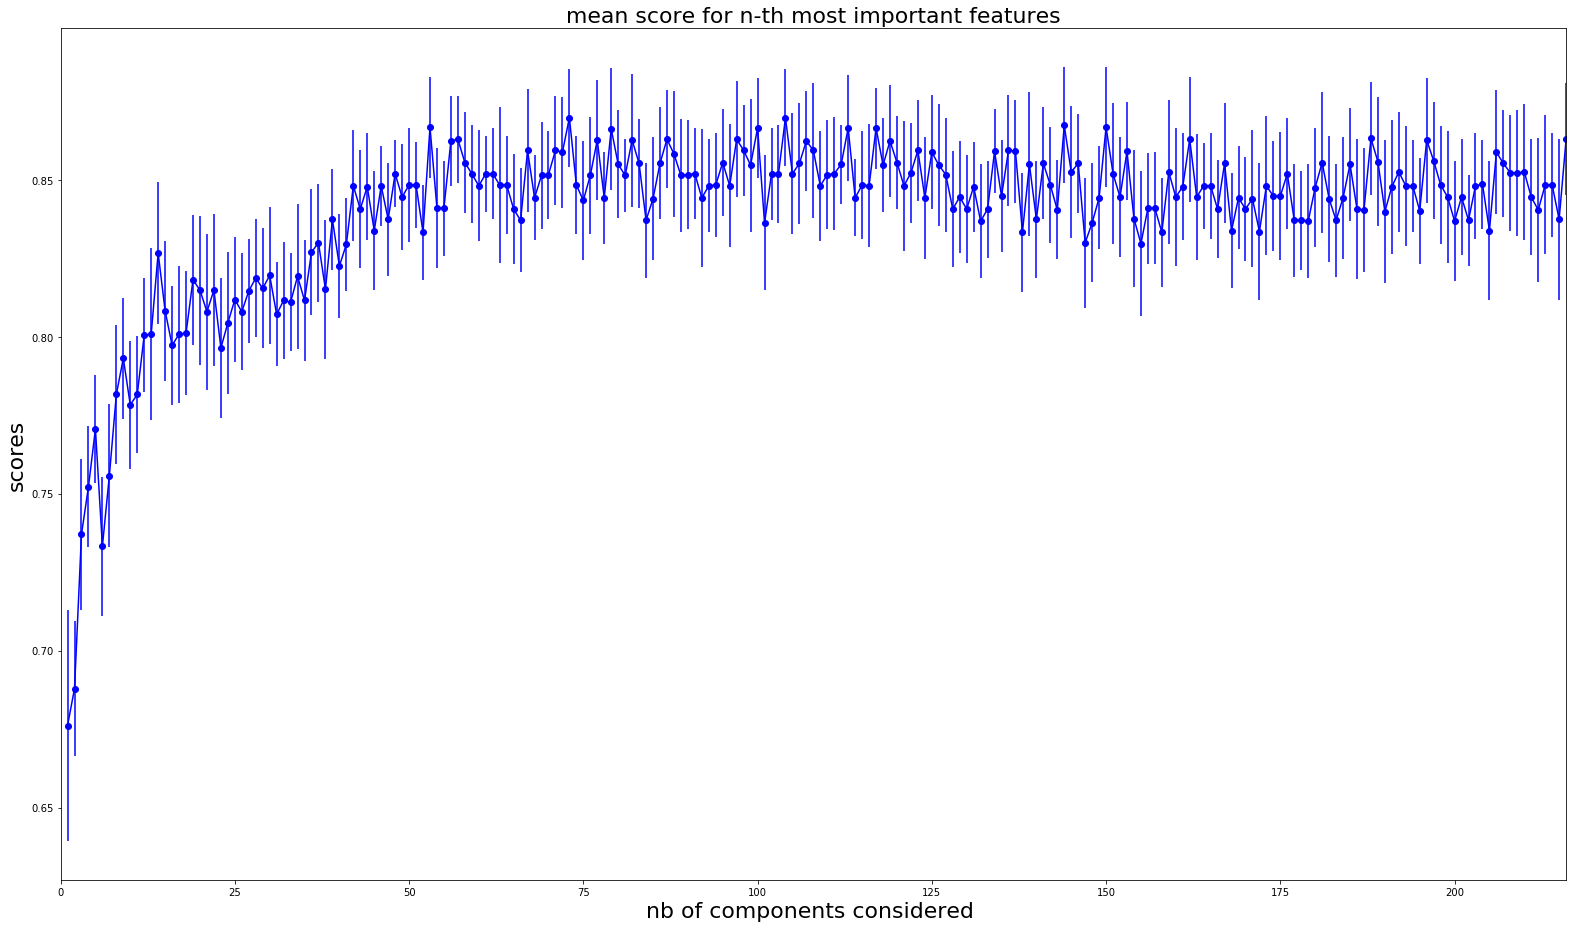

In [33]:
plot_score_with_components(most_important_features, score_mean, error_on_mean_score, sort_feat_import_df)

## Entrainement sur un récepteur et prédiction sur un autre

In [34]:
receiver = 50

y = labelize(sumH, receiver)
X = extractFeatures(sum_traces_grouped, receiver)

clf = ExtraTreesClassifier(n_estimators=200)
clf.fit(X, y)

classification_metrics(y, clf.predict(X))

Feature Extraction: 100%|██████████| 270/270 [00:22<00:00, 11.74it/s]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       135
        1.0       1.00      1.00      1.00       135

avg / total       1.00      1.00      1.00       270



In [35]:
receiver = 51

y = labelize(sumH, receiver)
X = extractFeatures(sum_traces_grouped, receiver)

classification_metrics(y, clf.predict(X))

Feature Extraction: 100%|██████████| 270/270 [00:23<00:00, 11.63it/s]

             precision    recall  f1-score   support

        0.0       0.52      0.92      0.66       135
        1.0       0.65      0.15      0.24       135

avg / total       0.58      0.53      0.45       270



## Prédiction pour plusieurs récepteurs

In [38]:
def fitPredictAllReceivers(receivers, sumH, sum_traces_grouped, traces, echantillonage=2, debug=True):
    """
    Entraîner et prédire un classifieur pour chaque récepteur
    """
    for receiver in receivers:
        if receiver % echantillonage == 0:
            print("Recepteur %d" %(receiver))
            y = labelize(sumH, receiver)
            X = extractFeatures(sum_traces_grouped, receiver, "main_features")
            new_X = extractFeatures(traces, receiver, "main_features")

            clf = ExtraTreesClassifier(n_estimators=200)
            clf.fit(X, y)
            new_y = clf.predict(new_X)
            
            if debug:
                y_pred = cross_val_predict(clf, X, y, cv=10)
                classification_metrics(y, y_pred)

In [ ]:
%time fitPredictAllReceivers(range(n3_convH), sumH, sum_traces_grouped, n_convH, echantillonage=2, debug=True)

## Pédiction pour plusieurs fichiers et récepteurs

In [36]:
def fitPredictAllFiles(files, n_tracesByGroups=20, echantillonage=2, debug=True):
    """
    Entraîner et prédire un classifieur pour chaque récepteur des fichiers
    """
    for file in files:
        print("Fichier %s" %(file))
        convH = load_data(file)
        n_convH = normalize_signals(convH)
        sum_traces, sum_traces_grouped = compute_sums(n_convH, n_tracesByGroups)
        sumH = compute_SSE(sum_traces, sum_traces_grouped)
        
        fitPredictAllReceivers(range(n3_convH), sumH, sum_traces_grouped,
                               n_convH, echantillonage, debug=debug)

In [41]:
fitPredictAllFiles(some_files, n_tracesByGroups=20, echantillonage=10, debug=True)

Fichier SUHA_Paris2017/conBR_ir031_tostack.rsf@


KeyboardInterrupt: 